In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = True
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

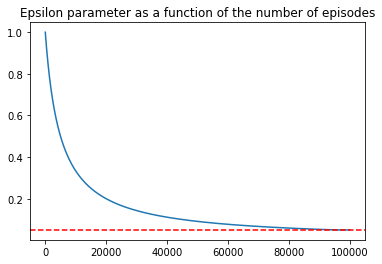

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 20

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9806 Discounted reward:  -17.098673095377226
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9617 Discounted reward:  -18.6425373790268
Episode: 300. Elapsed time  0.18  minuts. epsilon 0.9436 Discounted reward:  -19.300878407255887
Episode: 400. Elapsed time  0.26  minuts. epsilon 0.9261 Discounted reward:  -13.25565725439777
Episode: 500. Elapsed time  0.35  minuts. epsilon 0.9093 Discounted reward:  -18.00688521472107
Episode: 600. Elapsed time  0.45  minuts. epsilon 0.893 Discounted reward:  -17.915113237456552
Episode: 700. Elapsed time  0.55  minuts. epsilon 0.8773 Discounted reward:  -23.28259039626888
Episode: 800. Elapsed time  0.66  minuts. epsilon 0.8622 Discounted reward:  -15.495622171015553
Episode: 900. Elapsed time  0.78  minuts. epsilon 0.8476 Discounted reward:  -14.971645910612708
Episode: 1000. Elapsed time  0.9  minuts. epsilon 0.8335 Discounted reward:  -19.962276977378032
Episode: 1100. Elapsed time  1.03  m

Episode: 8600. Elapsed time  20.29  minuts. epsilon 0.3677 Discounted reward:  -8.76853033063095
Episode: 8700. Elapsed time  20.62  minuts. epsilon 0.365 Discounted reward:  -3.7692039004040203
Episode: 8800. Elapsed time  20.93  minuts. epsilon 0.3623 Discounted reward:  -8.984360472509078
Episode: 8900. Elapsed time  21.27  minuts. epsilon 0.3597 Discounted reward:  -7.817619787835582
Episode: 9000. Elapsed time  21.59  minuts. epsilon 0.3572 Discounted reward:  -9.503625120225468
Episode: 9100. Elapsed time  21.95  minuts. epsilon 0.3546 Discounted reward:  -7.469245608954084
Episode: 9200. Elapsed time  22.27  minuts. epsilon 0.3521 Discounted reward:  -4.206782168653245
Episode: 9300. Elapsed time  22.57  minuts. epsilon 0.3497 Discounted reward:  -7.59201079955405
Episode: 9400. Elapsed time  22.89  minuts. epsilon 0.3472 Discounted reward:  -4.698068988013798
Episode: 9500. Elapsed time  23.23  minuts. epsilon 0.3449 Discounted reward:  -11.29148378000162
Episode: 9600. Elapsed

Episode: 16900. Elapsed time  50.69  minuts. epsilon 0.2283 Discounted reward:  -5.06027784118363
Episode: 17000. Elapsed time  51.06  minuts. epsilon 0.2273 Discounted reward:  -2.209316744776151
Episode: 17100. Elapsed time  51.49  minuts. epsilon 0.2263 Discounted reward:  -5.677038688427422
Episode: 17200. Elapsed time  51.9  minuts. epsilon 0.2252 Discounted reward:  -3.3742268836612492
Episode: 17300. Elapsed time  52.31  minuts. epsilon 0.2242 Discounted reward:  -5.928544231796048
Episode: 17400. Elapsed time  52.72  minuts. epsilon 0.2232 Discounted reward:  -5.765838146121364
Episode: 17500. Elapsed time  53.14  minuts. epsilon 0.2222 Discounted reward:  -1.8033931061551367
Episode: 17600. Elapsed time  53.51  minuts. epsilon 0.2212 Discounted reward:  -3.306221418440713
Episode: 17700. Elapsed time  53.88  minuts. epsilon 0.2203 Discounted reward:  -5.470981892871722
Episode: 17800. Elapsed time  54.25  minuts. epsilon 0.2193 Discounted reward:  -2.9139026835973487
Episode: 

Episode: 25200. Elapsed time  85.68  minuts. epsilon 0.1656 Discounted reward:  -6.289102518428609
Episode: 25300. Elapsed time  86.07  minuts. epsilon 0.165 Discounted reward:  -4.033418245279183
Episode: 25400. Elapsed time  86.49  minuts. epsilon 0.1645 Discounted reward:  -1.9222341498968925
Episode: 25500. Elapsed time  86.95  minuts. epsilon 0.1639 Discounted reward:  -5.253666279504416
Episode: 25600. Elapsed time  87.36  minuts. epsilon 0.1634 Discounted reward:  -8.55488016407996
Episode: 25700. Elapsed time  87.77  minuts. epsilon 0.1629 Discounted reward:  -2.158512526137692
Episode: 25800. Elapsed time  88.2  minuts. epsilon 0.1623 Discounted reward:  -4.427468969155656
Episode: 25900. Elapsed time  88.61  minuts. epsilon 0.1618 Discounted reward:  -3.0888408811026364
Episode: 26000. Elapsed time  89.0  minuts. epsilon 0.1613 Discounted reward:  -1.2783443173571711
Episode: 26100. Elapsed time  89.4  minuts. epsilon 0.1608 Discounted reward:  -1.6830868225528164
Episode: 26

Episode: 33400. Elapsed time  120.84  minuts. epsilon 0.1302 Discounted reward:  -2.2396209699477994
Episode: 33500. Elapsed time  121.25  minuts. epsilon 0.1299 Discounted reward:  -2.5798030162211965
Episode: 33600. Elapsed time  121.66  minuts. epsilon 0.1295 Discounted reward:  -1.8363191088049293
Episode: 33700. Elapsed time  122.07  minuts. epsilon 0.1292 Discounted reward:  -1.6725793990227742
Episode: 33800. Elapsed time  122.48  minuts. epsilon 0.1289 Discounted reward:  -2.442478259686242
Episode: 33900. Elapsed time  122.95  minuts. epsilon 0.1285 Discounted reward:  -3.732728617483826
Episode: 34000. Elapsed time  123.39  minuts. epsilon 0.1282 Discounted reward:  -4.702015839788964
Episode: 34100. Elapsed time  123.84  minuts. epsilon 0.1279 Discounted reward:  -4.197716756159827
Episode: 34200. Elapsed time  124.28  minuts. epsilon 0.1276 Discounted reward:  -1.1207201801996134
Episode: 34300. Elapsed time  124.72  minuts. epsilon 0.1272 Discounted reward:  -2.17689841714

Episode: 41600. Elapsed time  157.4  minuts. epsilon 0.1073 Discounted reward:  -1.3943450012360086
Episode: 41700. Elapsed time  157.89  minuts. epsilon 0.1071 Discounted reward:  -4.074772020439394
Episode: 41800. Elapsed time  158.33  minuts. epsilon 0.1068 Discounted reward:  -2.370336247564804
Episode: 41900. Elapsed time  158.74  minuts. epsilon 0.1066 Discounted reward:  -1.1331203545444832
Episode: 42000. Elapsed time  159.19  minuts. epsilon 0.1064 Discounted reward:  -1.6161295252673369
Episode: 42100. Elapsed time  159.62  minuts. epsilon 0.1062 Discounted reward:  -3.24694824408359
Episode: 42200. Elapsed time  160.14  minuts. epsilon 0.1059 Discounted reward:  -2.9582118181776935
Episode: 42300. Elapsed time  160.59  minuts. epsilon 0.1057 Discounted reward:  -3.7941950242277054
Episode: 42400. Elapsed time  161.0  minuts. epsilon 0.1055 Discounted reward:  -1.3271700811079308
Episode: 42500. Elapsed time  161.42  minuts. epsilon 0.1053 Discounted reward:  -2.6898543695100

Episode: 49800. Elapsed time  195.53  minuts. epsilon 0.0912 Discounted reward:  -3.3515782530682947
Episode: 49900. Elapsed time  195.96  minuts. epsilon 0.0911 Discounted reward:  -1.6468424548168747
Episode: 50000. Elapsed time  196.38  minuts. epsilon 0.0909 Discounted reward:  -2.4114538566631945
Episode: 50100. Elapsed time  196.83  minuts. epsilon 0.0907 Discounted reward:  -2.572017765210171
Episode: 50200. Elapsed time  197.39  minuts. epsilon 0.0906 Discounted reward:  -0.7493195348637288
Episode: 50300. Elapsed time  197.89  minuts. epsilon 0.0904 Discounted reward:  -4.763979208283565
Episode: 50400. Elapsed time  198.42  minuts. epsilon 0.0903 Discounted reward:  -1.855841818416133
Episode: 50500. Elapsed time  198.93  minuts. epsilon 0.0901 Discounted reward:  -3.1088562682870777
Episode: 50600. Elapsed time  199.37  minuts. epsilon 0.0899 Discounted reward:  -1.3867588797720232
Episode: 50700. Elapsed time  199.79  minuts. epsilon 0.0898 Discounted reward:  -3.6011894873

Episode: 58000. Elapsed time  234.15  minuts. epsilon 0.0794 Discounted reward:  -2.8305285829963127
Episode: 58100. Elapsed time  234.62  minuts. epsilon 0.0792 Discounted reward:  -2.277317819858381
Episode: 58200. Elapsed time  235.09  minuts. epsilon 0.0791 Discounted reward:  -3.255685753671781
Episode: 58300. Elapsed time  235.58  minuts. epsilon 0.079 Discounted reward:  -1.5168226111379466
Episode: 58400. Elapsed time  236.06  minuts. epsilon 0.0789 Discounted reward:  -1.6198420011131656
Episode: 58500. Elapsed time  236.54  minuts. epsilon 0.0787 Discounted reward:  -1.2221798170660645
Episode: 58600. Elapsed time  236.98  minuts. epsilon 0.0786 Discounted reward:  -0.7757273187698326
Episode: 58700. Elapsed time  237.42  minuts. epsilon 0.0785 Discounted reward:  -4.47497234211182
Episode: 58800. Elapsed time  237.85  minuts. epsilon 0.0784 Discounted reward:  -2.5371843777823955
Episode: 58900. Elapsed time  238.3  minuts. epsilon 0.0782 Discounted reward:  -1.1327235674841

Episode: 66200. Elapsed time  273.13  minuts. epsilon 0.0702 Discounted reward:  -2.3622437264104588
Episode: 66300. Elapsed time  273.65  minuts. epsilon 0.0701 Discounted reward:  -0.6752310792616285
Episode: 66400. Elapsed time  274.11  minuts. epsilon 0.07 Discounted reward:  -1.0804418336793247
Episode: 66500. Elapsed time  274.55  minuts. epsilon 0.0699 Discounted reward:  -0.983881646281694
Episode: 66600. Elapsed time  275.02  minuts. epsilon 0.0698 Discounted reward:  -1.7089956104877482
Episode: 66700. Elapsed time  275.48  minuts. epsilon 0.0697 Discounted reward:  -0.8654169621743335
Episode: 66800. Elapsed time  275.99  minuts. epsilon 0.0696 Discounted reward:  -0.7689551998845339
Episode: 66900. Elapsed time  276.53  minuts. epsilon 0.0695 Discounted reward:  -1.439199808459537
Episode: 67000. Elapsed time  276.97  minuts. epsilon 0.0694 Discounted reward:  -1.7406906270614033
Episode: 67100. Elapsed time  277.42  minuts. epsilon 0.0693 Discounted reward:  -2.01036585079

Episode: 74400. Elapsed time  312.94  minuts. epsilon 0.063 Discounted reward:  -2.344665190966825
Episode: 74500. Elapsed time  313.51  minuts. epsilon 0.0629 Discounted reward:  -3.1718123070914355
Episode: 74600. Elapsed time  313.95  minuts. epsilon 0.0628 Discounted reward:  -2.048372903820716
Episode: 74700. Elapsed time  314.39  minuts. epsilon 0.0627 Discounted reward:  -1.712367431748271
Episode: 74800. Elapsed time  314.86  minuts. epsilon 0.0627 Discounted reward:  -0.6306372986891621
Episode: 74900. Elapsed time  315.3  minuts. epsilon 0.0626 Discounted reward:  -1.1065277329476506
Episode: 75000. Elapsed time  315.75  minuts. epsilon 0.0625 Discounted reward:  -1.4707614519580938
Episode: 75100. Elapsed time  316.2  minuts. epsilon 0.0624 Discounted reward:  -3.106302032289942
Episode: 75200. Elapsed time  316.63  minuts. epsilon 0.0623 Discounted reward:  -2.803318505989894
Episode: 75300. Elapsed time  317.07  minuts. epsilon 0.0623 Discounted reward:  -0.772146698809567

Episode: 82600. Elapsed time  352.1  minuts. epsilon 0.0571 Discounted reward:  -1.3202948265928103
Episode: 82700. Elapsed time  352.57  minuts. epsilon 0.057 Discounted reward:  -2.247355294795704
Episode: 82800. Elapsed time  353.04  minuts. epsilon 0.0569 Discounted reward:  -2.6267416554013177
Episode: 82900. Elapsed time  353.49  minuts. epsilon 0.0569 Discounted reward:  -1.3240891572779487
Episode: 83000. Elapsed time  353.95  minuts. epsilon 0.0568 Discounted reward:  -1.124237896996277
Episode: 83100. Elapsed time  354.4  minuts. epsilon 0.0568 Discounted reward:  -4.9170191524587725
Episode: 83200. Elapsed time  354.85  minuts. epsilon 0.0567 Discounted reward:  -1.1887308728692063
Episode: 83300. Elapsed time  355.32  minuts. epsilon 0.0566 Discounted reward:  -2.9492522165798305
Episode: 83400. Elapsed time  355.82  minuts. epsilon 0.0566 Discounted reward:  -1.4986929846925094
Episode: 83500. Elapsed time  356.3  minuts. epsilon 0.0565 Discounted reward:  -1.4953027043989

Episode: 90800. Elapsed time  392.58  minuts. epsilon 0.0522 Discounted reward:  -1.5073692376961432
Episode: 90900. Elapsed time  393.05  minuts. epsilon 0.0521 Discounted reward:  -1.2612574110922758
Episode: 91000. Elapsed time  393.53  minuts. epsilon 0.0521 Discounted reward:  -1.5131460338503069
Episode: 91100. Elapsed time  393.99  minuts. epsilon 0.052 Discounted reward:  -1.953291425161239
Episode: 91200. Elapsed time  394.45  minuts. epsilon 0.052 Discounted reward:  -1.2680375902650314
Episode: 91300. Elapsed time  395.0  minuts. epsilon 0.0519 Discounted reward:  -2.628893779873895
Episode: 91400. Elapsed time  395.46  minuts. epsilon 0.0519 Discounted reward:  -0.8357920913197592
Episode: 91500. Elapsed time  395.92  minuts. epsilon 0.0518 Discounted reward:  -2.0825410301873184
Episode: 91600. Elapsed time  396.42  minuts. epsilon 0.0518 Discounted reward:  -2.0396263187360946
Episode: 91700. Elapsed time  396.88  minuts. epsilon 0.0517 Discounted reward:  -1.222436960323

Episode: 99100. Elapsed time  433.7  minuts. epsilon 0.05 Discounted reward:  -1.1854521824517021
Episode: 99200. Elapsed time  434.16  minuts. epsilon 0.05 Discounted reward:  -0.7576623112207442
Episode: 99300. Elapsed time  434.64  minuts. epsilon 0.05 Discounted reward:  -2.085874436403685
Episode: 99400. Elapsed time  435.1  minuts. epsilon 0.05 Discounted reward:  -1.2816383592619662
Episode: 99500. Elapsed time  435.56  minuts. epsilon 0.05 Discounted reward:  -1.5752734180144283
Episode: 99600. Elapsed time  436.02  minuts. epsilon 0.05 Discounted reward:  -1.398143900077838
Episode: 99700. Elapsed time  436.47  minuts. epsilon 0.05 Discounted reward:  -0.9437497781697708
Episode: 99800. Elapsed time  436.94  minuts. epsilon 0.05 Discounted reward:  -1.832620103221339
Episode: 99900. Elapsed time  437.51  minuts. epsilon 0.05 Discounted reward:  -1.767599052419533
Episode: 100000. Elapsed time  437.96  minuts. epsilon 0.05 Discounted reward:  -1.4270008642430323
Training finish

### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 100000#243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);





Test episode: 1


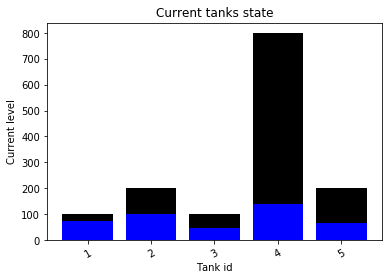

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

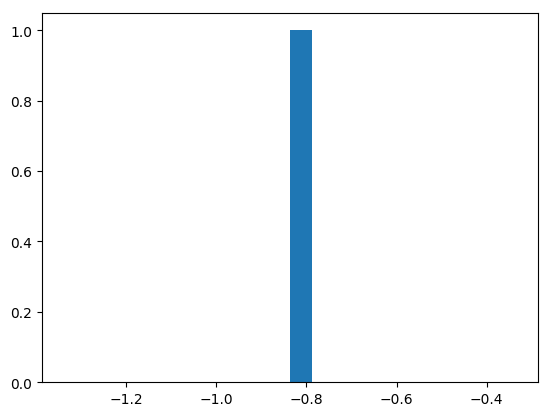

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

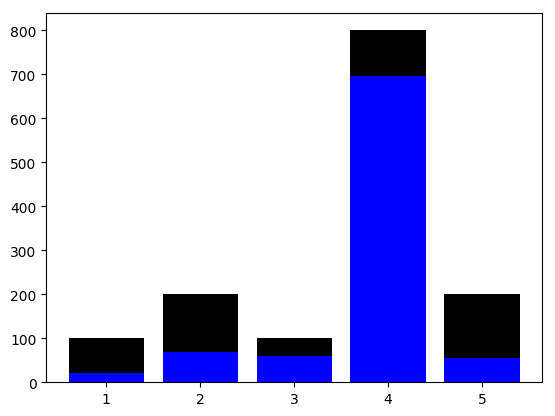

In [15]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


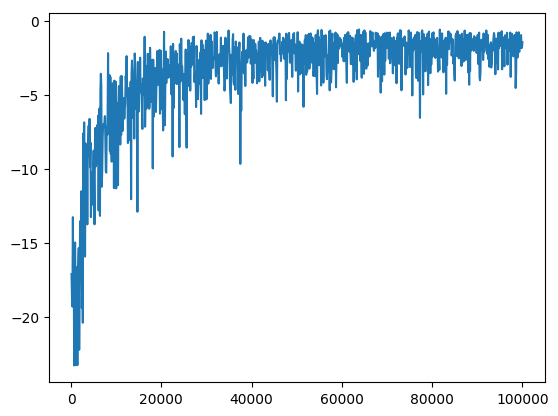

In [16]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

plt.plot(discrewards['episode'],discrewards['discreward'], label = "Discounted rewards")

plt.show()
plt.close()


In [17]:
len(list(Q))

27398

In [18]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

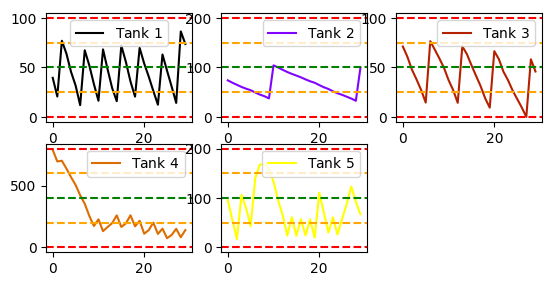

In [19]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

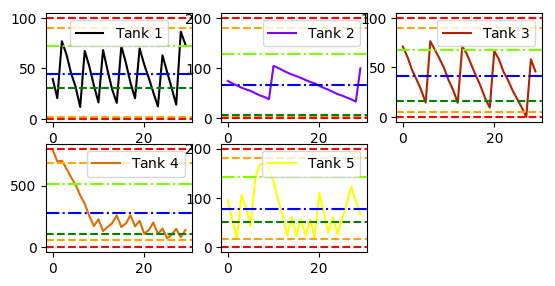

In [20]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

### Test visualization

In [21]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [22]:
def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.1163557 -0.0001728 0.1161829 0300
Episode 1 t 2 -0.9999808 -0.9999808 0.0 5500
Episode 1 t 3 -0.1620194 2.79e-05 0.1620473 1400
Episode 1 t 4 0.0001598 0.0001598 0.0 5500
Episode 1 t 5 -0.1624445 0.0006863 0.1631307 2400
Episode 1 t 6 -0.0115138 4.26e-05 0.0115564 0500
Episode 1 t 7 3.1e-05 3.1e-05 0.0 5500
Episode 1 t 8 1.77e-05 1.77e-05 0.0 5500
Episode 1 t 9 -0.160437 0.0005269 0.1609639 4300
Episode 1 t 10 -0.1161588 2.42e-05 0.1161829 0300
Episode 1 t 11 -0.1607823 0.0001816 0.1609639 4300
Episode 1 t 12 -0.163043 8.77e-05 0.1631307 2300
Episode 1 t 13 0.0011245 0.0011245 0.0 5500
Episode 1 t 14 -0.1161503 3.26e-05 0.1161829 0400
Episode 1 t 15 -0.1609393 2.47e-05 0.1609639 3300
Episode 1 t 16 1.23e-05 1.23e-05 0.0 5500
Episode 1 t 17 -0.1596059 0.001358 0.1609639 3300
Episode 1 t 18 -0.1155573 0.0006257 0.1161829 0400
Episode 1 t 19 -0.1631051 2.57e-05 0.1631307 2300
Episode 1 t 20 0.0006156 0.0006156 0

Episode 6 t 18 -0.1155842 0.0005987 0.1161829 0300
Episode 6 t 19 -0.1620252 2.22e-05 0.1620473 1400
Episode 6 t 20 -0.16311 2.08e-05 0.1631307 2300
Episode 6 t 21 0.0005489 0.0005489 0.0 5500
Episode 6 t 22 -0.1157243 0.0004586 0.1161829 0300
Episode 6 t 23 -0.1609386 2.53e-05 0.1609639 4300
Episode 6 t 24 0.0003717 0.0003717 0.0 5500
Episode 6 t 25 -0.1602999 0.000664 0.1609639 4300
Episode 6 t 26 -0.1161596 2.34e-05 0.1161829 0400
Episode 6 t 27 -0.1631011 2.96e-05 0.1631307 2300
Episode 6 t 28 -0.160874 8.99e-05 0.1609639 3300
Episode 6 t 29 0.0005824 0.0005824 0.0 5500
Test episode: 7
Episode 7 t 0 2.57e-05 2.57e-05 0.0 5500
Episode 7 t 1 -0.16094 2.39e-05 0.1609639 3300
Episode 7 t 2 0.0005273 0.0005273 0.0 5500
Episode 7 t 3 -0.161704 0.0003433 0.1620473 1400
Episode 7 t 4 -0.1161557 2.72e-05 0.1161829 0300
Episode 7 t 5 -0.1609372 2.67e-05 0.1609639 3300
Episode 7 t 6 -0.1609377 2.62e-05 0.1609639 4300
Episode 7 t 7 -0.1631095 2.12e-05 0.1631307 2300
Episode 7 t 8 0.0009467 0.0

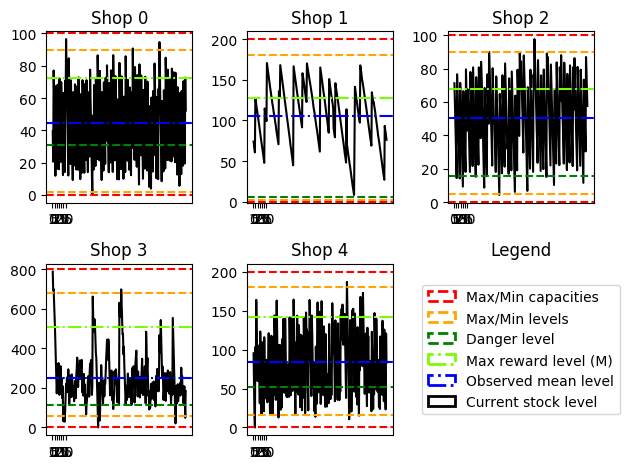

Total discounted rewards Level rewards Transport rewards
-0.967440598281956 -0.2931876721623853 3.0071929580999996
Average trucks sent:  41.6


In [23]:
test_simulation(simulation_id= 16, max_episodes = 100000,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.1163557 -0.0001728 0.1161829 0300
Episode 1 t 2 -0.1046013 2.52e-05 0.1046265 5400
Episode 1 t 3 1.95e-05 1.95e-05 0.0 5500
Episode 1 t 4 0.0004162 0.0004162 0.0 5500
Episode 1 t 5 -0.1624446 0.0006861 0.1631307 2400
Episode 1 t 6 -0.1213083 -0.0011013 0.120207 0200
Episode 1 t 7 1.77e-05 1.77e-05 0.0 5500
Episode 1 t 8 -0.0569486 0.0004722 0.0574208 1500
Episode 1 t 9 -0.1604352 0.0005288 0.1609639 4300
Episode 1 t 10 -0.0112468 0.0003096 0.0115564 0500
Episode 1 t 11 -0.1609437 2.02e-05 0.1609639 4300
Episode 1 t 12 -0.1042073 0.0004192 0.1046265 5300
Episode 1 t 13 -0.1604295 0.0005344 0.1609639 4300
Episode 1 t 14 -0.1198368 0.0003702 0.120207 0200
Episode 1 t 15 -0.1609421 2.18e-05 0.1609639 4300
Episode 1 t 16 -0.1606151 0.0003488 0.1609639 3300
Episode 1 t 17 -0.0559562 0.0003812 0.0563374 4500
Episode 1 t 18 -0.0110782 0.0004781 0.0115564 0500
Episode 1 t 19 -0.1609469 1.7e-05 0.1609639 4300
Episode 1

Episode 6 t 15 1.92e-05 1.92e-05 0.0 5500
Episode 6 t 16 -0.1600757 0.0008882 0.1609639 3300
Episode 6 t 17 -0.1161527 3.02e-05 0.1161829 0400
Episode 6 t 18 2.02e-05 2.02e-05 0.0 5500
Episode 6 t 19 -0.1046155 1.11e-05 0.1046265 5300
Episode 6 t 20 -0.1620903 0.0010404 0.1631307 2300
Episode 6 t 21 -0.1161502 3.28e-05 0.1161829 0400
Episode 6 t 22 -0.1609369 2.7e-05 0.1609639 3300
Episode 6 t 23 1.48e-05 1.48e-05 0.0 5500
Episode 6 t 24 -0.1597703 0.0011936 0.1609639 3300
Episode 6 t 25 -0.1161572 2.57e-05 0.1161829 0400
Episode 6 t 26 1.21e-05 1.21e-05 0.0 5500
Episode 6 t 27 -0.1631188 1.19e-05 0.1631307 2300
Episode 6 t 28 -0.1593986 0.0015653 0.1609639 3300
Episode 6 t 29 -1.1629628 -0.9999869 0.162976 4100
Test episode: 7
Episode 7 t 0 2.57e-05 2.57e-05 0.0 5500
Episode 7 t 1 5.23e-05 5.23e-05 0.0 5500
Episode 7 t 2 -0.1604366 0.0005273 0.1609639 3300
Episode 7 t 3 -0.0560016 0.0003358 0.0563374 4500
Episode 7 t 4 -0.1160442 0.0001387 0.1161829 0300
Episode 7 t 5 -0.1609408 2.31e

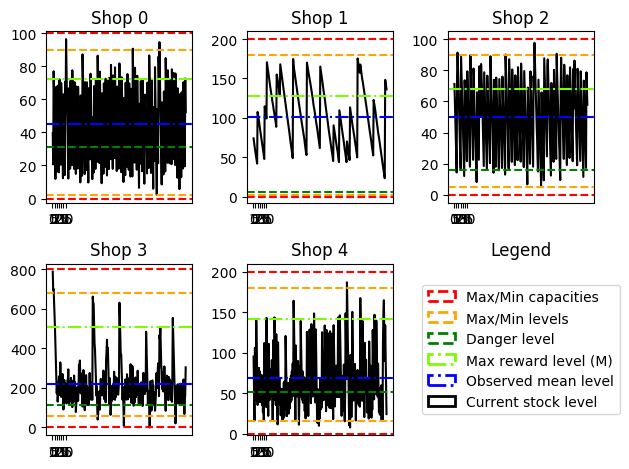

Total discounted rewards Level rewards Transport rewards
-0.8716437036551177 -0.19792093150096618 3.0420168830999996
Average trucks sent:  42.4


In [24]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.1163557 -0.0001728 0.1161829 0300
Episode 1 t 2 -0.9999808 -0.9999808 0.0 5500
Episode 1 t 3 -0.0560783 0.0002591 0.0563374 4500
Episode 1 t 4 -0.0561822 0.0001552 0.0563374 4500
Episode 1 t 5 -0.0575998 0.0009044 0.0585042 2500
Episode 1 t 6 -0.116145 3.8e-05 0.1161829 0400
Episode 1 t 7 -0.0573886 3.22e-05 0.0574208 1500
Episode 1 t 8 1.88e-05 1.88e-05 0.0 5500
Episode 1 t 9 -0.1038632 0.0007634 0.1046265 5300
Episode 1 t 10 -0.1161542 2.87e-05 0.1161829 0400
Episode 1 t 11 -0.1044482 0.0001784 0.1046265 5300
Episode 1 t 12 -0.1630463 8.44e-05 0.1631307 2300
Episode 1 t 13 -0.1035021 0.0011245 0.1046265 5300
Episode 1 t 14 -0.1161503 3.26e-05 0.1161829 0400
Episode 1 t 15 -0.1046036 2.29e-05 0.1046265 5300
Episode 1 t 16 -0.1046128 1.38e-05 0.1046265 5300
Episode 1 t 17 0.0013545 0.0013545 0.0 5500
Episode 1 t 18 -0.076628 0.0011713 0.0777992 4000
Episode 1 t 19 -1.1609193 -0.9999554 0.1609639 4300
Episode 

Episode 6 t 15 2.12e-05 2.12e-05 0.0 5500
Episode 6 t 16 -0.1042058 0.0004207 0.1046265 5300
Episode 6 t 17 -0.1172899 -0.0011069 0.1161829 0300
Episode 6 t 18 -0.0563 3.73e-05 0.0563374 4500
Episode 6 t 19 -0.1038011 0.0008255 0.1046265 5300
Episode 6 t 20 -0.1626404 0.0004904 0.1631307 2400
Episode 6 t 21 -0.1161534 2.95e-05 0.1161829 0300
Episode 6 t 22 0.0001748 0.0001748 0.0 5500
Episode 6 t 23 -0.103712 0.0009146 0.1046265 5300
Episode 6 t 24 -0.1603407 0.0006232 0.1609639 4300
Episode 6 t 25 -0.0107473 0.0008091 0.0115564 0500
Episode 6 t 26 -0.1609541 9.8e-06 0.1609639 4300
Episode 6 t 27 -0.1622845 0.0008463 0.1631307 2300
Episode 6 t 28 -0.0557155 0.0006219 0.0563374 4500
Episode 6 t 29 -0.0201492 0.0013127 0.0214619 5000
Test episode: 7
Episode 7 t 0 -0.0563099 2.74e-05 0.0563374 3500
Episode 7 t 1 2.06e-05 2.06e-05 0.0 5500
Episode 7 t 2 -0.0558116 0.0005258 0.0563374 3500
Episode 7 t 3 -0.1606263 0.0003376 0.1609639 4300
Episode 7 t 4 -0.1160425 0.0001405 0.1161829 0300
Ep

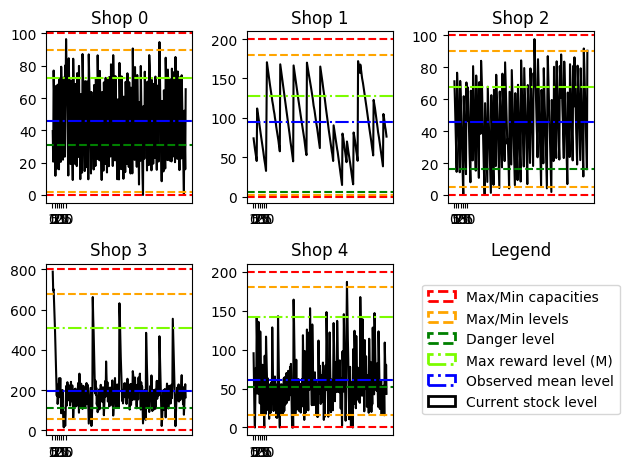

Total discounted rewards Level rewards Transport rewards
-1.027617607393368 -1.2062960712710864 2.908912103099999
Average trucks sent:  40.0


In [25]:
test_simulation(simulation_id= 18, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.116151 3.19e-05 0.1161829 0400
Episode 1 t 2 3.14e-05 3.14e-05 0.0 5500
Episode 1 t 3 2.18e-05 2.18e-05 0.0 5500
Episode 1 t 4 -0.0570014 0.0004193 0.0574208 1500
Episode 1 t 5 -0.1624415 0.0006892 0.1631307 2400
Episode 1 t 6 -0.1161423 4.06e-05 0.1161829 0300
Episode 1 t 7 2.9e-05 2.9e-05 0.0 5500
Episode 1 t 8 -0.1609371 2.68e-05 0.1609639 4300
Episode 1 t 9 -0.0558107 0.0005266 0.0563374 3500
Episode 1 t 10 -0.1158722 0.0003108 0.1161829 0300
Episode 1 t 11 -0.1607774 0.0001866 0.1609639 3400
Episode 1 t 12 -0.1630381 9.26e-05 0.1631307 2300
Episode 1 t 13 0.0005432 0.0005432 0.0 5500
Episode 1 t 14 -0.1155243 0.0006586 0.1161829 0300
Episode 1 t 15 -0.1609343 2.96e-05 0.1609639 3400
Episode 1 t 16 1.72e-05 1.72e-05 0.0 5500
Episode 1 t 17 -0.1605833 0.0003806 0.1609639 4300
Episode 1 t 18 -0.1155575 0.0006254 0.1161829 0300
Episode 1 t 19 -0.1631031 2.77e-05 0.1631307 2400
Episode 1 t 20 2.27e-05 2.27e-0

Episode 6 t 18 -0.1609382 2.57e-05 0.1609639 4300
Episode 6 t 19 1.33e-05 1.33e-05 0.0 5500
Episode 6 t 20 -0.1626459 0.0004849 0.1631307 2300
Episode 6 t 21 -0.1161498 3.32e-05 0.1161829 0400
Episode 6 t 22 -0.1609346 2.93e-05 0.1609639 3300
Episode 6 t 23 -0.1609419 2.2e-05 0.1609639 3300
Episode 6 t 24 0.000638 0.000638 0.0 5500
Episode 6 t 25 -0.1161557 2.73e-05 0.1161829 0400
Episode 6 t 26 1.44e-05 1.44e-05 0.0 5500
Episode 6 t 27 -0.0575708 0.0009334 0.0585042 2500
Episode 6 t 28 -0.1599574 0.0010065 0.1609639 3300
Episode 6 t 29 -0.2257434 -0.1095604 0.1161829 0300
Test episode: 7
Episode 7 t 0 -0.1609332 3.07e-05 0.1609639 3300
Episode 7 t 1 2.39e-05 2.39e-05 0.0 5500
Episode 7 t 2 -0.1604316 0.0005324 0.1609639 3300
Episode 7 t 3 -0.104279 0.0003475 0.1046265 5400
Episode 7 t 4 -0.1161528 3.01e-05 0.1161829 0300
Episode 7 t 5 -0.1609301 3.38e-05 0.1609639 4300
Episode 7 t 6 2.21e-05 2.21e-05 0.0 5500
Episode 7 t 7 -0.1631146 1.61e-05 0.1631307 2300
Episode 7 t 8 -0.1615546 0.

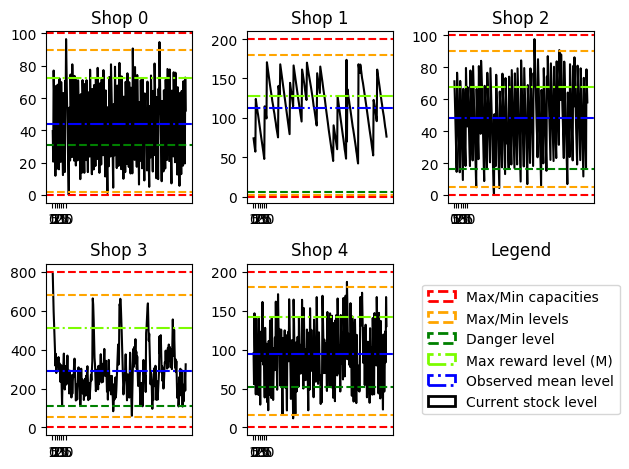

Total discounted rewards Level rewards Transport rewards
-0.9489059093196731 -0.2048540945878537 3.0763352162999995
Average trucks sent:  42.6


In [26]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes)

### Stochastic consumption rates WITH transport/unload costs, 100K episodes 


Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.1163557 -0.0001728 0.1161829 0300
Episode 1 t 2 -0.1046013 2.52e-05 0.1046265 5400
Episode 1 t 3 1.95e-05 1.95e-05 0.0 5500
Episode 1 t 4 -0.0561782 0.0001592 0.0563374 4500
Episode 1 t 5 -0.0578248 0.0006794 0.0585042 2500
Episode 1 t 6 -0.1160222 0.0001608 0.1161829 0300
Episode 1 t 7 -0.0563104 2.7e-05 0.0563374 4500
Episode 1 t 8 -0.0572243 0.0001965 0.0574208 1500
Episode 1 t 9 -0.055812 0.0005254 0.0563374 4500
Episode 1 t 10 -0.0115291 2.73e-05 0.0115564 0500
Episode 1 t 11 -0.1036031 0.0010234 0.1046265 5300
Episode 1 t 12 -0.1622229 0.0009079 0.1631307 2400
Episode 1 t 13 -0.160422 0.0005419 0.1609639 3300
Episode 1 t 14 -0.1158045 0.0003785 0.1161829 0300
Episode 1 t 15 -0.0563175 1.98e-05 0.0563374 4500
Episode 1 t 16 -0.1617081 0.0003393 0.1620473 1300
Episode 1 t 17 -0.1605879 0.000376 0.1609639 4300
Episode 1 t 18 -0.1207815 -0.0005745 0.120207 0200
Episode 1 t 19 -0.1609407 2.32e-05 0.1609639 4

Episode 6 t 14 -0.1044562 0.0001704 0.1046265 5300
Episode 6 t 15 -0.1609372 2.68e-05 0.1609639 4300
Episode 6 t 16 -0.0563142 2.32e-05 0.0563374 4500
Episode 6 t 17 -0.1616933 0.000354 0.1620473 1300
Episode 6 t 18 -0.1161417 4.13e-05 0.1161829 0300
Episode 6 t 19 -0.0563199 1.75e-05 0.0563374 4500
Episode 6 t 20 -0.1631147 1.6e-05 0.1631307 2300
Episode 6 t 21 -0.0557854 0.000552 0.0563374 4500
Episode 6 t 22 -0.1161547 2.82e-05 0.1161829 0300
Episode 6 t 23 -0.0556925 0.0006449 0.0563374 3500
Episode 6 t 24 -0.1608799 8.4e-05 0.1609639 4300
Episode 6 t 25 -0.0556718 0.0006656 0.0563374 4500
Episode 6 t 26 -0.1161622 2.07e-05 0.1161829 0300
Episode 6 t 27 -0.1625524 0.0005783 0.1631307 2300
Episode 6 t 28 -0.0562539 8.34e-05 0.0563374 4500
Episode 6 t 29 -0.1156117 0.0005712 0.1161829 0300
Test episode: 7
Episode 7 t 0 -0.0573972 2.35e-05 0.0574208 1500
Episode 7 t 1 5.11e-05 5.11e-05 0.0 5500
Episode 7 t 2 -0.1609403 2.36e-05 0.1609639 4300
Episode 7 t 3 -0.160624 0.0003399 0.160963

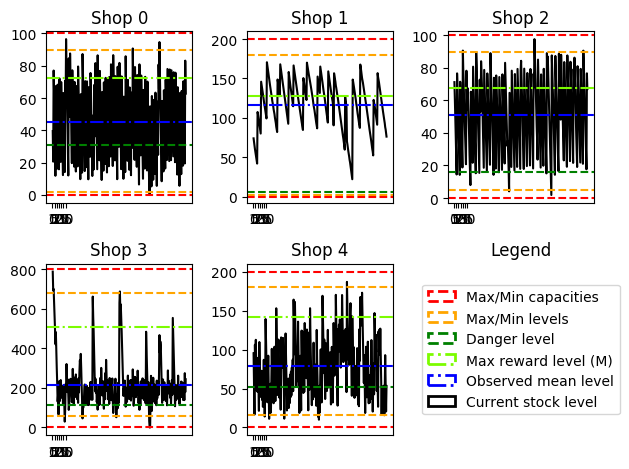

Total discounted rewards Level rewards Transport rewards
-0.9617267822265092 -0.2936295600290461 3.004917795
Average trucks sent:  43.2


In [27]:
test_simulation(simulation_id= 19, max_episodes = 100000,n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0007471 -0.0007471 0.0 5500
Episode 1 t 1 -0.1163557 -0.0001728 0.1161829 0300
Episode 1 t 2 -0.1046013 2.52e-05 0.1046265 5400
Episode 1 t 3 1.95e-05 1.95e-05 0.0 5500
Episode 1 t 4 0.0004162 0.0004162 0.0 5500
Episode 1 t 5 -0.1624446 0.0006861 0.1631307 2400
Episode 1 t 6 -0.1161516 3.13e-05 0.1161829 0400
Episode 1 t 7 -0.0563145 2.29e-05 0.0563374 4500
Episode 1 t 8 -0.0563209 1.65e-05 0.0563374 4500
Episode 1 t 9 -0.1615171 0.0005303 0.1620473 1300
Episode 1 t 10 -0.0115321 2.43e-05 0.0115564 0500
Episode 1 t 11 -0.1044526 0.0001739 0.1046265 5300
Episode 1 t 12 -0.1622585 0.0008723 0.1631307 2300
Episode 1 t 13 -0.1604223 0.0005416 0.1609639 4300
Episode 1 t 14 -0.0107333 0.0008231 0.0115564 0500
Episode 1 t 15 -0.1609444 1.96e-05 0.1609639 4300
Episode 1 t 16 -0.1038401 0.0007864 0.1046265 5300
Episode 1 t 17 -0.0559667 0.0003706 0.0563374 4500
Episode 1 t 18 -0.1146608 0.0015221 0.1161829 0300
Episode 1 t 19 -0.1630753 5.54e-05 0.1631307 2400
E

Episode 6 t 16 -0.1042058 0.0004207 0.1046265 5300
Episode 6 t 17 -0.1172899 -0.0011069 0.1161829 0300
Episode 6 t 18 -0.0563 3.73e-05 0.0563374 4500
Episode 6 t 19 -0.1038011 0.0008255 0.1046265 5300
Episode 6 t 20 -0.1626404 0.0004904 0.1631307 2400
Episode 6 t 21 -0.1161534 2.95e-05 0.1161829 0300
Episode 6 t 22 0.0001748 0.0001748 0.0 5500
Episode 6 t 23 -0.103712 0.0009146 0.1046265 5300
Episode 6 t 24 -0.1603407 0.0006232 0.1609639 4300
Episode 6 t 25 -0.0107473 0.0008091 0.0115564 0500
Episode 6 t 26 -0.1609541 9.8e-06 0.1609639 4300
Episode 6 t 27 -0.1622845 0.0008463 0.1631307 2300
Episode 6 t 28 -0.1039979 0.0006286 0.1046265 5400
Episode 6 t 29 -0.0325287 0.0004896 0.0330182 0000
Test episode: 7
Episode 7 t 0 -0.0573972 2.35e-05 0.0574208 1500
Episode 7 t 1 5.11e-05 5.11e-05 0.0 5500
Episode 7 t 2 -0.1041011 0.0005254 0.1046265 5300
Episode 7 t 3 -0.1606258 0.0003381 0.1609639 4300
Episode 7 t 4 -0.1160406 0.0001424 0.1161829 0300
Episode 7 t 5 -0.0563131 2.43e-05 0.0563374 

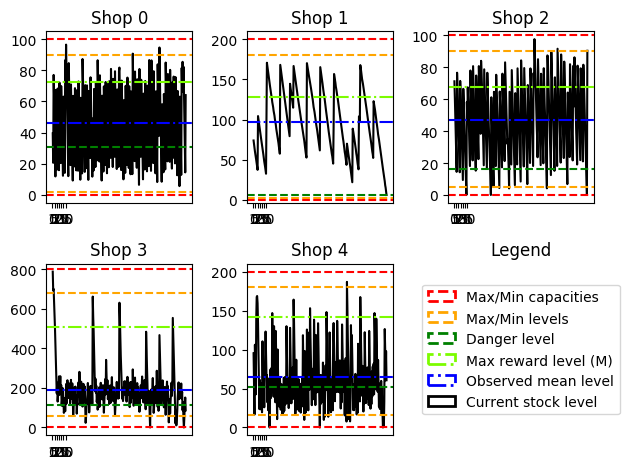

Total discounted rewards Level rewards Transport rewards
-0.9475045888200466 -1.0943214989749654 2.9268915665999997
Average trucks sent:  40.0


In [28]:
test_simulation(simulation_id= 20, max_episodes = 100000,n_episodes = test_episodes)